# Deep Model for EEG signals 

Link: https://www.kaggle.com/byrachonok/pretrained-inceptionresnetv2-base-classifier
        

# Prepare data

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras
import efficientnet.tfkeras as efn

from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D

print("GPU available:",tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: True


# Load Data

(1280, 4)


,Valence,Arousal,Dominance,Liking
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,0,1,1,1
4,1,0,1,1


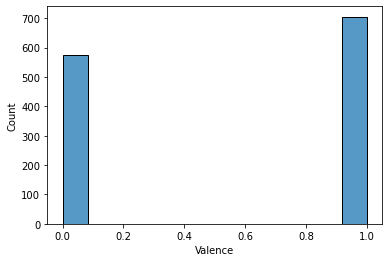

In [4]:
df = pd.read_csv('Encoded_target.csv')
print(df.shape)
sns.histplot(df['Valence'])
df.head()

In [5]:
df['path'] = df.index.map(lambda x: os.path.join('data','5ch_image_{}.jpg'.format(x)))
df.head()

,Valence,Arousal,Dominance,Liking,path
0,1,1,1,1,data/5ch_image_0.jpg
1,1,1,1,1,data/5ch_image_1.jpg
2,1,1,1,1,data/5ch_image_2.jpg
3,0,1,1,1,data/5ch_image_3.jpg
4,1,0,1,1,data/5ch_image_4.jpg


In [6]:
train_ids, valid_ids = train_test_split(df.index, 
                                   test_size = 0.20, 
                                   random_state = 123,
                                   stratify = df['Valence'])

train_df = df.iloc[train_ids].reset_index(drop=True)
valid_df = df.iloc[valid_ids].reset_index(drop=True)
print('train:', train_df.shape[0])
print('validation:', valid_df.shape[0])

train: 1024
validation: 256


In [7]:
def scale(img):
    img = img.astype(np.float32)
    img /= 127.5
    img -= 1
    return img

def unscale(img):
    return ((img + 1.0)*127.5).astype(np.uint8)

In [8]:
# training data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.,
    preprocessing_function=scale
)   

train_batches = train_datagen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="Valence",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="raw",
    batch_size=32,
    shuffle=True,
)

# training data generator
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0,
    preprocessing_function=scale,
)

valid_batches = valid_datagen.flow_from_dataframe(
    valid_df, 
    x_col="path",
    y_col="Valence",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="raw",
    batch_size=32,
    shuffle=True,
)


Found 1024 validated image filenames.
Found 256 validated image filenames.


Frequency distribution: {1: 17, 0: 15}


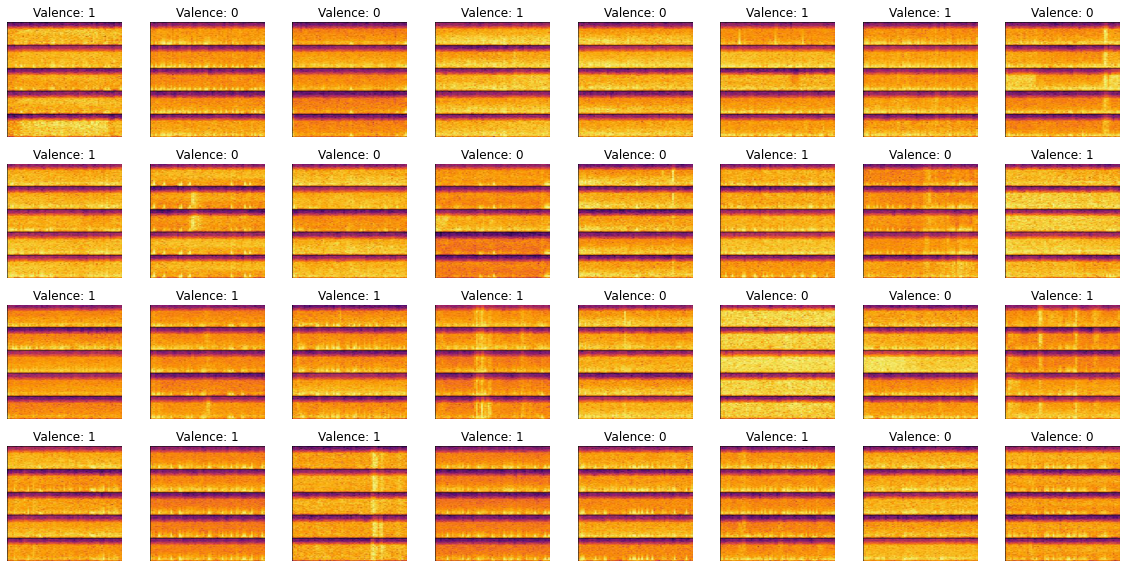

Frequency distribution: {0: 15, 1: 17}


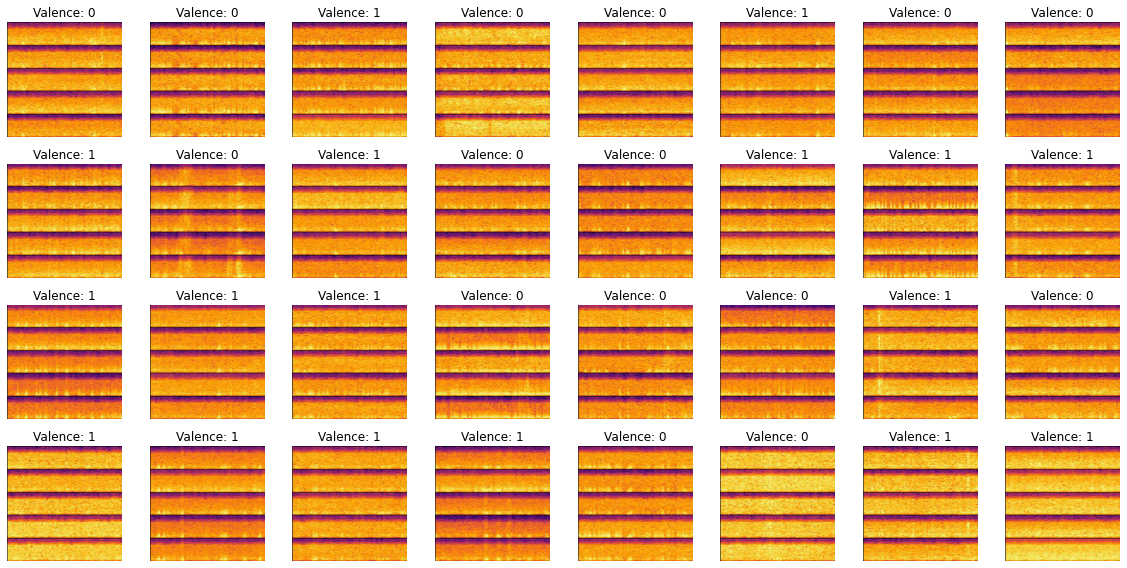

In [9]:
def show_batch(x_gen, figs_per_row=8):
    from collections import defaultdict
    stats = defaultdict(int)
    x, y = x_gen.next()
    rows, columns = math.ceil(32/figs_per_row), figs_per_row
    fig=plt.figure(figsize=(columns*2, rows*2))
    for i in range(columns*rows):
        img, label = x[i, :, :, :], y[i]
        fig.add_subplot(rows, columns, i+1)
        plt.title(f"Valence: {label}")
        stats[label] += 1
        plt.imshow(unscale(img))
        plt.axis('off')
        #print("image min-max:", np.min(img), np.max(img))
    plt.tight_layout()
    print("Frequency distribution:", dict(stats))
    plt.show()
    
show_batch(train_batches)
show_batch(valid_batches)

# Model implementation

In [20]:
def create_model():

    bmargs = {
    'weights': 'imagenet', 
    'include_top': False, 
    'input_shape': (224, 224, 3)
    }
    #base_model = VGG16(**bmargs)    
    #base_model = tf.keras.applications.ResNet50(**bmargs)
    base_model = getattr(efn, "EfficientNetB1")(**bmargs)
    # apply regularization on base_model
    for layer in base_model.layers:
        layer.kernel_regularizer = tf.keras.regularizers.l2(0.001)
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation= 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation= 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation= 'sigmoid')(x)
    model = Model(inputs = base_model.input, outputs = predictions)
    
    # Compile the model
    adam = Adam(lr=0.0001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing =0.05)
    sgd = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0, nesterov=True)
    model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
model = create_model()
# model.summary()

In [24]:
# early stop
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=10, verbose=1)

# reduced learning rate
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto', verbose=1, factor=0.333, patience=3, min_lr=0)

In [26]:
model.fit_generator(
    generator=train_batches,
    steps_per_epoch=train_batches.samples//32,
    validation_data=valid_batches,
    validation_steps=valid_batches.samples//32,
    epochs=100,
    callbacks=[earlystop, reducelr],
 )

Epoch 1/100
32/32 [==============================] - 7s 223ms/step - loss: 0.4803 - accuracy: 0.9385 - val_loss: 1.3119 - val_accuracy: 0.5898 - lr: 1.2296e-06
Epoch 2/100
32/32 [==============================] - 7s 226ms/step - loss: 0.4584 - accuracy: 0.9512 - val_loss: 1.2468 - val_accuracy: 0.6133 - lr: 1.2296e-06
Epoch 3/100
32/32 [==============================] - 7s 226ms/step - loss: 0.4794 - accuracy: 0.9434 - val_loss: 1.2596 - val_accuracy: 0.6094 - lr: 1.2296e-06
Epoch 4/100
32/32 [==============================] - 7s 230ms/step - loss: 0.4739 - accuracy: 0.9395 - val_loss: 1.3027 - val_accuracy: 0.5938 - lr: 1.2296e-06
Epoch 5/100
32/32 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.9502
Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.0946910451111763e-07.
32/32 [==============================] - 7s 228ms/step - loss: 0.4558 - accuracy: 0.9502 - val_loss: 1.2673 - val_accuracy: 0.6133 - lr: 1.2296e-06
Epoch 6/100
32/32 [=================